# IMDB verisi üzerinde Bidirectional LSTM'in Basit Bir Uygulaması

Bu notebook'da IMDB film inceleme duyarlılığı sınıflandırma veri kümesinde 2 katmanlı çift yönlü bir LSTM eğiteceğiz.

## Kurulum

In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

max_features = 20000  # Yalnızca ilk 20 bin kelimeyi dikkate alın
maxlen = 200  # Her film incelemesinin yalnızca ilk 200 kelimesini dikkate alın


## Modeli oluşturalım

In [ ]:
# Değişken uzunluklu tamsayı dizileri için girdi
inputs = keras.Input(shape=(None,), dtype="int32")
# Her tamsayıyı 128 boyutlu bir vektöre gömün
x = layers.Embedding(max_features, 128)(inputs)
# 2 çift yönlü LSTM ekleyin
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
# Sınıflandırıcı ekle
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.summary()


## IMDB film incelemesi için duyarlılık verilerini yükleyin

In [ ]:
(x_train, y_train), (x_val, y_val) = keras.datasets.imdb.load_data(
    num_words=max_features
)
print(len(x_train), "Eğitim dizileri")
print(len(x_val), "Doğrulama dizileri")
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_val = keras.preprocessing.sequence.pad_sequences(x_val, maxlen=maxlen)


## Modeli eğitin ve değerlendirin

Ayrıca [Hugging Face Hub](https://huggingface.co/keras-io/bidirectional-lstm-imdb) üzerinde barındırılan eğitimli modeli kullanabilirdi..

In [ ]:
model.compile("adam", "binary_crossentropy", metrics=["accuracy"])
model.fit(x_train, y_train, batch_size=32, epochs=2, validation_data=(x_val, y_val))


## Model parametrelerini optimize edelim

In [ ]:
# model parametrelerin optimize edilmesi.
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

def create_model(optimizer='adam'):
    model = keras.Sequential()
    model.add(layers.Embedding(max_features, 128))
    model.add(layers.Bidirectional(layers.LSTM(64, return_sequences=True)))
    model.add(layers.Bidirectional(layers.LSTM(64)))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=create_model, verbose=0)
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [2, 3, 5, 10]
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(batch_size=batch_size, epochs=epochs, optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_train, y_train)

# en iyi parametreler
print("En iyi parametreler: %s with a score of %f" % (grid_result.best_params_, grid_result.best_score_))

# en iyi parametreler ile modelin yeniden eğitilmesi
model = create_model(optimizer = 'Adam')
model.fit(x_train, y_train, batch_size=100, epochs=10, validation_data=(x_val, y_val))

# modelin test verileri ile test edilmesi
model.evaluate(x_val, y_val)

## Aynı proje üzerinden mimari sabit kalarak optimizer'in değiştirilmesi ( Lion )

Aşağıda Lion Optimizer'in kodu bulunmakta. Bunu direkt olarak https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Lion belirtildiği üzere de kullanabilirsiniz. İncelemenizi tavsiye ederim. 

In [ ]:

"""TF2 implementation of the Lion optimizer."""

import tensorflow.compat.v2 as tf


class Lion(tf.keras.optimizers.legacy.Optimizer):
  r"""Optimizer that implements the Lion algorithm."""

  def __init__(self,
               learning_rate=0.0001,
               beta_1=0.9,
               beta_2=0.99,
               wd=0,
               name='lion',
               **kwargs):
    """Construct a new Lion optimizer."""

    super(Lion, self).__init__(name, **kwargs)
    self._set_hyper('learning_rate', kwargs.get('lr', learning_rate))
    self._set_hyper('beta_1', beta_1)
    self._set_hyper('beta_2', beta_2)
    self._set_hyper('wd', wd)

  def _create_slots(self, var_list):
    # Create slots for the first and second moments.
    # Separate for-loops to respect the ordering of slot variables from v1.
    for var in var_list:
      self.add_slot(var, 'm')

  def _prepare_local(self, var_device, var_dtype, apply_state):
    super(Lion, self)._prepare_local(var_device, var_dtype, apply_state)

    beta_1_t = tf.identity(self._get_hyper('beta_1', var_dtype))
    beta_2_t = tf.identity(self._get_hyper('beta_2', var_dtype))
    wd_t = tf.identity(self._get_hyper('wd', var_dtype))
    lr = apply_state[(var_device, var_dtype)]['lr_t']
    apply_state[(var_device, var_dtype)].update(
        dict(
            lr=lr,
            beta_1_t=beta_1_t,
            one_minus_beta_1_t=1 - beta_1_t,
            beta_2_t=beta_2_t,
            one_minus_beta_2_t=1 - beta_2_t,
            wd_t=wd_t))

  @tf.function(jit_compile=True)
  def _resource_apply_dense(self, grad, var, apply_state=None):
    var_device, var_dtype = var.device, var.dtype.base_dtype
    coefficients = ((apply_state or {}).get((var_device, var_dtype)) or
                    self._fallback_apply_state(var_device, var_dtype))

    m = self.get_slot(var, 'm')
    var_t = var.assign_sub(
        coefficients['lr_t'] *
        (tf.math.sign(m * coefficients['beta_1_t'] +
                      grad * coefficients['one_minus_beta_1_t']) +
         var * coefficients['wd_t']))
    with tf.control_dependencies([var_t]):
      m.assign(m * coefficients['beta_2_t'] +
               grad * coefficients['one_minus_beta_2_t'])

  @tf.function(jit_compile=True)
  def _resource_apply_sparse(self, grad, var, indices, apply_state=None):
    var_device, var_dtype = var.device, var.dtype.base_dtype
    coefficients = ((apply_state or {}).get((var_device, var_dtype)) or
                    self._fallback_apply_state(var_device, var_dtype))

    m = self.get_slot(var, 'm')
    m_t = m.assign(m * coefficients['beta_1_t'])
    m_scaled_g_values = grad * coefficients['one_minus_beta_1_t']
    m_t = m_t.scatter_add(tf.IndexedSlices(m_scaled_g_values, indices))
    var_t = var.assign_sub(coefficients['lr'] *
                           (tf.math.sign(m_t) + var * coefficients['wd_t']))

    with tf.control_dependencies([var_t]):
      m_t = m_t.scatter_add(tf.IndexedSlices(-m_scaled_g_values, indices))
      m_t = m_t.assign(m_t * coefficients['beta_2_t'] /
                       coefficients['beta_1_t'])
      m_scaled_g_values = grad * coefficients['one_minus_beta_2_t']
      m_t.scatter_add(tf.IndexedSlices(m_scaled_g_values, indices))

  def get_config(self):
    config = super(Lion, self).get_config()
    config.update({
        'learning_rate': self._serialize_hyperparameter('learning_rate'),
        'beta_1': self._serialize_hyperparameter('beta_1'),
        'beta_2': self._serialize_hyperparameter('beta_2'),
        'wd': self._serialize_hyperparameter('wd'),
    })
    return config


import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

max_features = 20000  # Yalnızca ilk 20 bin kelimeyi dikkate alın
maxlen = 200  # Her film incelemesinin yalnızca ilk 200 kelimesini dikkate alın
# Değişken uzunluklu tamsayı dizileri için girdi
inputs = keras.Input(shape=(None,), dtype="int32")
# Her tamsayıyı 128 boyutlu bir vektöre gömün
x = layers.Embedding(max_features, 128)(inputs)
# 2 çift yönlü LSTM ekleyin
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
# Sınıflandırıcı ekle
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.summary()
(x_train, y_train), (x_val, y_val) = keras.datasets.imdb.load_data(
    num_words=max_features
)
print(len(x_train), "Eğitim dizileri")
print(len(x_val), "Doğrulama dizileri")
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_val = keras.preprocessing.sequence.pad_sequences(x_val, maxlen=maxlen)

#model.compile("adam", "binary_crossentropy", metrics=["accuracy"])
#model.fit(x_train, y_train, batch_size=32, epochs=2, validation_data=(x_val, y_val))
# adam optimizer yerine Lion optimizer kullanıldı
model.compile(Lion(), "binary_crossentropy", metrics=["accuracy"])
model.fit(x_train, y_train, batch_size=32, epochs=5, validation_data=(x_val, y_val))


## Torch İle Test'ler

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
100%|██████████| 50000/50000 [00:00<00:00, 87798.45it/s]


<Figure size 500x800 with 0 Axes>

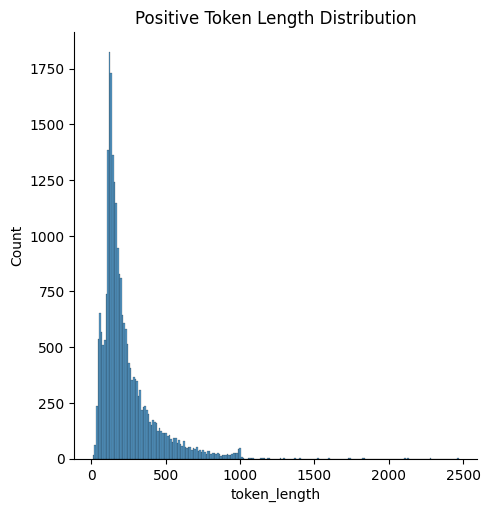

<Figure size 500x800 with 0 Axes>

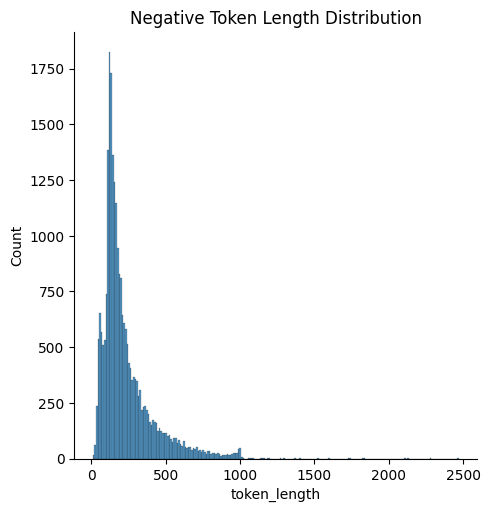

Positive
Brilliant and moving performances by Tom Courtenay and Peter Finch.

Negative
Primary plot!Primary direction!Poor interpretation.


100%|██████████| 50000/50000 [01:52<00:00, 446.30it/s]


One reviewer mentioned watching Oz episode hooked . They right , exactly happened . The first thing struck Oz brutality unflinching scene violence , set right word GO . Trust , show faint hearted timid . This show pull punch regard drug , sex violence . Its hardcore , classic use word . It called OZ nickname given Oswald Maximum Security State Penitentary . It focus mainly Emerald City , experimental section prison cell glass front face inwards , privacy high agenda . Em City home many . . Aryans , Muslims , gangsta , Latinos , Christians , Italians , Irish . . . . scuffle , death stare , dodgy dealing shady agreement never far away . I would say main appeal show due fact go show dare . Forget pretty picture painted mainstream audience , forget charm , forget romance . . . OZ mess around . The first episode I ever saw struck nasty surreal , I say I ready , I watched , I developed taste Oz , got accustomed high level graphic violence . Not violence , injustice crooked guard sold nickel 

100%|██████████| 50000/50000 [00:01<00:00, 28811.58it/s]


[191, 1083, 930, 81, 3724]
[47, 328, 59, 244, 1]
[3, 95, 328, 30, 1041]
[2408, 136, 59, 241, 3230]
[70982, 10566, 1081, 1941, 7538]
Feature Shapes:
Train set: (35000, 256)
Validation set: (7500, 256)
Test set: (7500, 256)
17510 17490
3753 3747
3737 3763
cuda
SentimentModel(
  (embedding): Embedding(121301, 256)
  (lstm): LSTM(256, 512, num_layers=2, batch_first=True, dropout=0.25, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=1024, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


Training:  12%|█▎        | 1/8 [02:57<20:43, 177.60s/it, Val Loss: 0.699 | Val Acc: 0.502]

Epoch 1/8 | Train Loss: 0.699 Train Acc: 0.500 | Val Loss: 0.699 Val Acc: 0.502


Training:  38%|███▊      | 3/8 [06:03<10:22, 124.51s/it, Training batch 0/274]            

Epoch 2/8 | Train Loss: 0.697 Train Acc: 0.503 | Val Loss: 0.700 Val Acc: 0.507
[WARNING] Validation loss did not improved (0.699 --> 0.700)


Training:  62%|██████▎   | 5/8 [09:08<07:25, 148.36s/it, Training batch 0/274]            

Epoch 3/8 | Train Loss: 0.689 Train Acc: 0.517 | Val Loss: 0.704 Val Acc: 0.521
[WARNING] Validation loss did not improved (0.699 --> 0.704)


Training:  75%|███████▌  | 6/8 [12:13<03:57, 118.75s/it, Val Loss: 0.676 | Val Acc: 0.602]

Epoch 4/8 | Train Loss: 0.662 Train Acc: 0.584 | Val Loss: 0.676 Val Acc: 0.602


Training:  88%|████████▊ | 7/8 [15:18<02:16, 137.00s/it, Val Loss: 0.648 | Val Acc: 0.662]

Epoch 5/8 | Train Loss: 0.567 Train Acc: 0.724 | Val Loss: 0.648 Val Acc: 0.662


Training: 9it [18:22, 123.03s/it, Val Loss: 0.599 | Val Acc: 0.715]                      

Epoch 6/8 | Train Loss: 0.491 Train Acc: 0.776 | Val Loss: 0.599 Val Acc: 0.715


Training: 10it [21:27, 140.84s/it, Val Loss: 0.577 | Val Acc: 0.738]

Epoch 7/8 | Train Loss: 0.417 Train Acc: 0.823 | Val Loss: 0.577 Val Acc: 0.738


Training: 11it [24:31, 153.50s/it, Val Loss: 0.551 | Val Acc: 0.764]

Epoch 8/8 | Train Loss: 0.360 Train Acc: 0.856 | Val Loss: 0.551 Val Acc: 0.764


Training: 100%|██████████| 8/8 [24:31<00:00, 183.94s/it, Val Loss: 0.551 | Val Acc: 0.764]


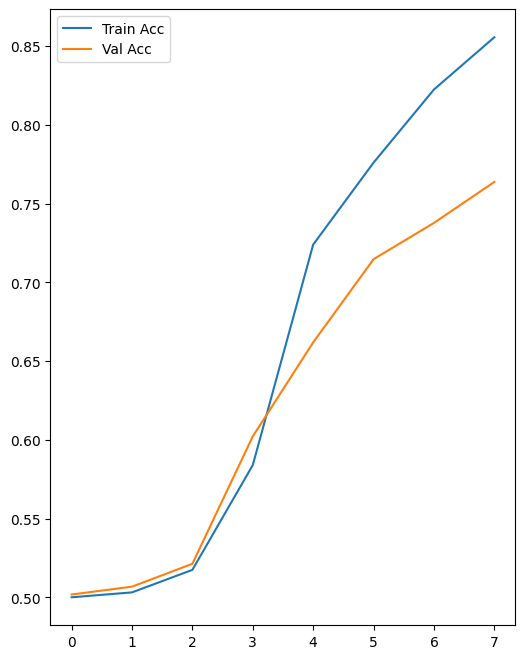

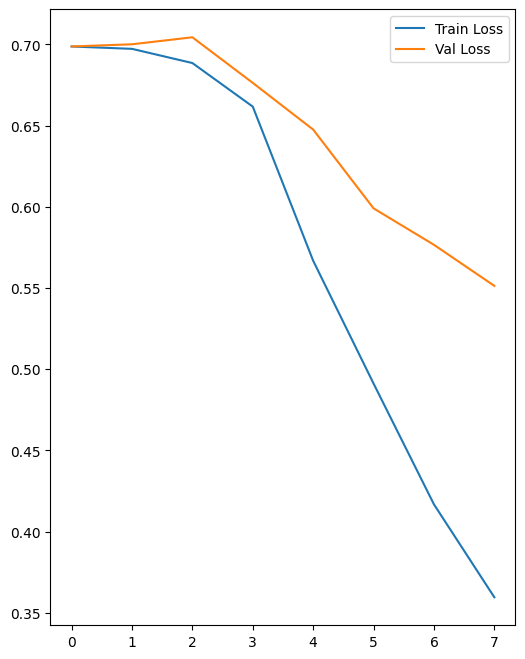

Inference: 100%|██████████| 59/59 [00:11<00:00,  5.00it/s]

Accuracy: 0.7606, Loss: 0.5511


In [2]:
###############################
# PYTORCH İLE TESTLER
###############################

import torch
from torch.optim.optimizer import Optimizer


class Lion(Optimizer):
  r"""Implements Lion algorithm."""

  def __init__(self, params, lr=1e-4, betas=(0.9, 0.99), weight_decay=0.0):
    """Initialize the hyperparameters.

    Args:
      params (iterable): iterable of parameters to optimize or dicts defining
        parameter groups
      lr (float, optional): learning rate (default: 1e-4)
      betas (Tuple[float, float], optional): coefficients used for computing
        running averages of gradient and its square (default: (0.9, 0.99))
      weight_decay (float, optional): weight decay coefficient (default: 0)
    """

    if not 0.0 <= lr:
      raise ValueError('Invalid learning rate: {}'.format(lr))
    if not 0.0 <= betas[0] < 1.0:
      raise ValueError('Invalid beta parameter at index 0: {}'.format(betas[0]))
    if not 0.0 <= betas[1] < 1.0:
      raise ValueError('Invalid beta parameter at index 1: {}'.format(betas[1]))
    defaults = dict(lr=lr, betas=betas, weight_decay=weight_decay)
    super().__init__(params, defaults)

  @torch.no_grad()
  def step(self, closure=None):
    """Performs a single optimization step.

    Args:
      closure (callable, optional): A closure that reevaluates the model
        and returns the loss.

    Returns:
      the loss.
    """
    loss = None
    if closure is not None:
      with torch.enable_grad():
        loss = closure()

    for group in self.param_groups:
      for p in group['params']:
        if p.grad is None:
          continue

        # Perform stepweight decay
        p.data.mul_(1 - group['lr'] * group['weight_decay'])

        grad = p.grad
        state = self.state[p]
        # State initialization
        if len(state) == 0:
          # Exponential moving average of gradient values
          state['exp_avg'] = torch.zeros_like(p)

        exp_avg = state['exp_avg']
        beta1, beta2 = group['betas']

        # Weight update
        update = exp_avg * beta1 + grad * (1 - beta1)
        p.add_(torch.sign(update), alpha=-group['lr'])
        # Decay the momentum running average coefficient
        exp_avg.mul_(beta2).add_(grad, alpha=1 - beta2)

    return loss

# data manipulation
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# text processing
import re
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stopwords = set(stopwords.words('english'))

# pytorch
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader

# sklearn
from sklearn.metrics import classification_report, confusion_matrix

# utils
import os
from tqdm import tqdm
tqdm.pandas()
from collections import Counter
data = pd.read_csv('/content/IMDB Dataset.csv')
data.head()

def transform_label(label):
    return 1 if label == 'positive' else 0

data['label'] = data['sentiment'].progress_apply(transform_label)
data.head()

data.sentiment.value_counts()

data['token_length'] = data.review.progress_apply(lambda x: len(x.split()))

data_pos = data[data['label'] == 1]
data_pos['token_length'].describe()

data_neg = data[data['label'] == 0]
data_neg['token_length'].describe()

plt.figure(figsize=(5, 8))
sns.displot(data_pos, x='token_length')
plt.title('Positive Token Length Distribution')
plt.show()

plt.figure(figsize=(5, 8))
sns.displot(data_pos, x='token_length')
plt.title('Negative Token Length Distribution')
plt.show()

# see most minimum length token
print('Positive')
print(data_pos[data_pos['token_length'] == data_pos['token_length'].min()]['review'].item())
print()
print('Negative')
print(data_neg[data_neg['token_length'] == data_neg['token_length'].min()]['review'].item())

# text cleaning

def rm_link(text):
    return re.sub(r'https?://\S+|www\.\S+', '', text)

# handle case like "shut up okay?Im only 10 years old"
# become "shut up okay Im only 10 years old"
def rm_punct2(text):
    # return re.sub(r'[\!\"\#\$\%\&\'\(\)\*\+\,\-\.\/\:\;\<\=\>\?\@\[\\\]\^\_\`\{\|\}\~]', ' ', text)
    return re.sub(r'[\"\#\$\%\&\'\(\)\*\+\/\:\;\<\=\>\@\[\\\]\^\_\`\{\|\}\~]', ' ', text)

def rm_html(text):
    return re.sub(r'<[^>]+>', '', text)

def space_bt_punct(text):
    pattern = r'([.,!?-])'
    s = re.sub(pattern, r' \1 ', text)     # add whitespaces between punctuation
    s = re.sub(r'\s{2,}', ' ', s)        # remove double whitespaces    
    return s

def rm_number(text):
    return re.sub(r'\d+', '', text)

def rm_whitespaces(text):
    return re.sub(r' +', ' ', text)

def rm_nonascii(text):
    return re.sub(r'[^\x00-\x7f]', r'', text)

def rm_emoji(text):
    emojis = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE
    )
    return emojis.sub(r'', text)

def spell_correction(text):
    return re.sub(r'(.)\1+', r'\1\1', text)

def clean_pipeline(text):    
    no_link = rm_link(text)
    no_html = rm_html(no_link)
    space_punct = space_bt_punct(no_html)
    no_punct = rm_punct2(space_punct)
    no_number = rm_number(no_punct)
    no_whitespaces = rm_whitespaces(no_number)
    no_nonasci = rm_nonascii(no_whitespaces)
    no_emoji = rm_emoji(no_nonasci)
    spell_corrected = spell_correction(no_emoji)
    return spell_corrected

# preprocessing
def tokenize(text):
    return word_tokenize(text)

def rm_stopwords(text):
    return [i for i in text if i not in stopwords]

def lemmatize(text):
    lemmatizer = WordNetLemmatizer()    
    lemmas = [lemmatizer.lemmatize(t) for t in text]
    # make sure lemmas does not contains sotpwords
    return rm_stopwords(lemmas)

def preprocess_pipeline(text):
    tokens = tokenize(text)
    no_stopwords = rm_stopwords(tokens)
    lemmas = lemmatize(no_stopwords)
    return ' '.join(lemmas)

data['clean'] = data['review'].progress_apply(clean_pipeline)
data['processed'] = data['clean'].progress_apply(preprocess_pipeline)
data.head()

# keep only processed and label columns
data[['processed', 'label']].to_csv('./imdb_processed.csv', index=False, header=True)

# read processed data
data = pd.read_csv('./imdb_processed.csv')

for row in data[:2].iterrows():
    print(row[1]['processed'])
    print(f'Label: {row[1]["label"]}')    
    print('\n')

# get all processed reviews
reviews = data.processed.values
# merge into single variable, separated by whitespaces
words = ' '.join(reviews)
# obtain list of words
words = words.split()

# check our list
words[:10]

# build vocabulary
counter = Counter(words)
vocab = sorted(counter, key=counter.get, reverse=True)
int2word = dict(enumerate(vocab, 1))
int2word[0] = '<PAD>'
word2int = {word: id for id, word in int2word.items()}

# encode words
reviews_enc = [[word2int[word] for word in review.split()] for review in tqdm(reviews)]

# print first-10 words of first 5 reviews
for i in range(5):
    print(reviews_enc[i][:5])

# padding sequences

def pad_features(reviews, pad_id, seq_length=128):
    # features = np.zeros((len(reviews), seq_length), dtype=int)
    features = np.full((len(reviews), seq_length), pad_id, dtype=int)

    for i, row in enumerate(reviews):
        # if seq_length < len(row) then review will be trimmed
        features[i, :len(row)] = np.array(row)[:seq_length]

    return features

seq_length = 256
features = pad_features(reviews_enc, pad_id=word2int['<PAD>'], seq_length=seq_length)

assert len(features) == len(reviews_enc)
assert len(features[0]) == seq_length

features[:10, :10]

# get labels as numpy
labels = data.label.to_numpy()
labels

# train test split
train_size = .7     # we will use 80% of whole data as train set
val_size = .5       # and we will use 50% of test set as validation set

# make train set
split_id = int(len(features) * train_size)
train_x, remain_x = features[:split_id], features[split_id:]
train_y, remain_y = labels[:split_id], labels[split_id:]

# make val and test set
split_val_id = int(len(remain_x) * val_size)
val_x, test_x = remain_x[:split_val_id], remain_x[split_val_id:]
val_y, test_y = remain_y[:split_val_id], remain_y[split_val_id:]

# print out the shape
print('Feature Shapes:')
print('===============')
print('Train set: {}'.format(train_x.shape))
print('Validation set: {}'.format(val_x.shape))
print('Test set: {}'.format(test_x.shape))

print(len(train_y[train_y == 0]), len(train_y[train_y == 1]))
print(len(val_y[val_y == 0]), len(val_y[val_y == 1]))
print(len(test_y[test_y == 0]), len(test_y[test_y == 1]))

# define batch size
batch_size = 128

# create tensor datasets
trainset = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
validset = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
testset = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

# create dataloaders
trainloader = DataLoader(trainset, shuffle=True, batch_size=batch_size)
valloader = DataLoader(validset, shuffle=True, batch_size=batch_size)
testloader = DataLoader(testset, shuffle=True, batch_size=batch_size)



# model architecture

class SentimentModel(nn.Module):
    def __init__(self, vocab_size, output_size, hidden_size=128, embedding_size=400, n_layers=2, dropout=0.2):
        super(SentimentModel, self).__init__()

    # embedding layer is useful to map input into vector representation
        self.embedding = nn.Embedding(vocab_size, embedding_size)

        # LSTM layer preserved by PyTorch library
        self.lstm = nn.LSTM(embedding_size, hidden_size, n_layers, dropout=dropout, bidirectional=True, batch_first=True)

        # dropout layer
        self.dropout = nn.Dropout(0.3)

        # Linear layer for output
        self.fc = nn.Linear(hidden_size*2, output_size)

        # Sigmoid layer cz we will have binary classification
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        
        # convert feature to long
        x = x.long()

        # map input to vector
        x = self.embedding(x)

        # pass forward to lstm
        o, _ =  self.lstm(x)

        # get last sequence output
        o = o[:, -1, :]

        # apply dropout and fully connected layer
        o = self.dropout(o)
        o = self.fc(o)

        # sigmoid
        o = self.sigmoid(o)

        return o
    

# define training device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# model hyperparamters
vocab_size = len(word2int)
output_size = 1
embedding_size = 256
hidden_size = 512
n_layers = 2
dropout=0.25

# model initialization
model = SentimentModel(vocab_size, output_size, hidden_size, embedding_size, n_layers, dropout)
print(model)

# training config
lr = 0.001
criterion = nn.BCELoss()  # we use BCELoss cz we have binary classification problem
#optim = Adam(model.parameters(), lr=lr)
# lion optimizer
optim = Lion(model.parameters(), lr=lr)
grad_clip = 5
epochs = 8
print_every = 1
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'epochs': epochs
}
es_limit = 5

# train loop
model = model.to(device)

epochloop = tqdm(range(epochs), position=0, desc='Training', leave=True)

# early stop trigger
es_trigger = 0
val_loss_min = torch.inf

for e in epochloop:

    #################
    # training mode #
    #################

    model.train()

    train_loss = 0
    train_acc = 0

    for id, (feature, target) in enumerate(trainloader):
        # add epoch meta info
        epochloop.set_postfix_str(f'Training batch {id}/{len(trainloader)}')

        # move to device
        feature, target = feature.to(device), target.to(device)

        # reset optimizer
        optim.zero_grad()

        # forward pass
        out = model(feature)

        # acc
        predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
        equals = predicted == target
        acc = torch.mean(equals.type(torch.FloatTensor))
        train_acc += acc.item()

        # loss
        loss = criterion(out.squeeze(), target.float())
        train_loss += loss.item()
        loss.backward()

        # clip grad
        nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

        # update optimizer
        optim.step()

        # free some memory
        del feature, target, predicted

    history['train_loss'].append(train_loss / len(trainloader))
    history['train_acc'].append(train_acc / len(trainloader))

    ####################
    # validation model #
    ####################

    model.eval()

    val_loss = 0
    val_acc = 0

    with torch.no_grad():
        for id, (feature, target) in enumerate(valloader):
            # add epoch meta info
            epochloop.set_postfix_str(f'Validation batch {id}/{len(valloader)}')
            
            # move to device
            feature, target = feature.to(device), target.to(device)

            # forward pass
            out = model(feature)

            # acc
            predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
            equals = predicted == target
            acc = torch.mean(equals.type(torch.FloatTensor))
            val_acc += acc.item()

            # loss
            loss = criterion(out.squeeze(), target.float())
            val_loss += loss.item()

            # free some memory
            del feature, target, predicted

        history['val_loss'].append(val_loss / len(valloader))
        history['val_acc'].append(val_acc / len(valloader))

    # reset model mode
    model.train()

    # add epoch meta info
    epochloop.set_postfix_str(f'Val Loss: {val_loss / len(valloader):.3f} | Val Acc: {val_acc / len(valloader):.3f}')

    # print epoch
    if (e+1) % print_every == 0:
        epochloop.write(f'Epoch {e+1}/{epochs} | Train Loss: {train_loss / len(trainloader):.3f} Train Acc: {train_acc / len(trainloader):.3f} | Val Loss: {val_loss / len(valloader):.3f} Val Acc: {val_acc / len(valloader):.3f}')
        epochloop.update()

    # save model if validation loss decrease
    if val_loss / len(valloader) <= val_loss_min:
        torch.save(model.state_dict(), './sentiment_lstm.pt')
        val_loss_min = val_loss / len(valloader)
        es_trigger = 0
    else:
        epochloop.write(f'[WARNING] Validation loss did not improved ({val_loss_min:.3f} --> {val_loss / len(valloader):.3f})')
        es_trigger += 1

    # force early stop
    if es_trigger >= es_limit:
        epochloop.write(f'Early stopped at Epoch-{e+1}')
        # update epochs history
        history['epochs'] = e+1
        break
    

# plot loss
plt.figure(figsize=(6, 8))
plt.plot(range(history['epochs']), history['train_acc'], label='Train Acc')
plt.plot(range(history['epochs']), history['val_acc'], label='Val Acc')
plt.legend()
plt.show()

# plot loss
plt.figure(figsize=(6, 8))
plt.plot(range(history['epochs']), history['train_loss'], label='Train Loss')
plt.plot(range(history['epochs']), history['val_loss'], label='Val Loss')
plt.legend()
plt.show()

# test loop
model.eval()

# metrics
test_loss = 0
test_acc = 0

all_target = []
all_predicted = []

testloop = tqdm(testloader, leave=True, desc='Inference')
with torch.no_grad():
    for feature, target in testloop:
        feature, target = feature.to(device), target.to(device)

        out = model(feature)
        
        predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
        equals = predicted == target
        acc = torch.mean(equals.type(torch.FloatTensor))
        test_acc += acc.item()

        loss = criterion(out.squeeze(), target.float())
        test_loss += loss.item()

        all_target.extend(target.cpu().numpy())
        all_predicted.extend(predicted.cpu().numpy())

    print(f'Accuracy: {test_acc/len(testloader):.4f}, Loss: {test_loss/len(testloader):.4f}')